# 4. Übungsblatt: Implementieren eines Perzeptronenmodels
## 1. Daten einlesen
Lesen Sie zunächst die Dateien `Train.txt` und `Val.txt` ein. Die ersten beiden Spalten beider Dateien entsprechen den Eingabedaten. Die dritte bzw. letzte Spalte entspricht den Labels. Trennen Sie die Daten so auf, dass:


*   `x_train` alle Eingabedaten für das Training enthält.
*   `y_train` alle Labels für das Training enthält.
*   `x_val` alle Eingabedaten für die Validierung enthält.
*   `y_val` alle Labels für die Validierung enthält.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import heapq as hq
# Damit die Ergebnisse reproduzierbar sind.
np.random.seed(1)

path_train = os.getcwd() + os.sep + "Train.txt"
path_val = os.getcwd() + os.sep + "Val.txt"

data_train = np.loadtxt(path_train).transpose()
data_val = np.loadtxt(path_val).transpose()

x_train = [data_train[0],data_train[1]]
y_train = data_train[2]

x_val = [data_val[0],data_val[1]]
y_val = data_val[2]

## 2. Visualisieren der Daten
Schreiben Sie eine Methode, die alle Trainings und Validierungsdaten visualisiert. Verwenden Sie hierfür das Paket matplotlib.

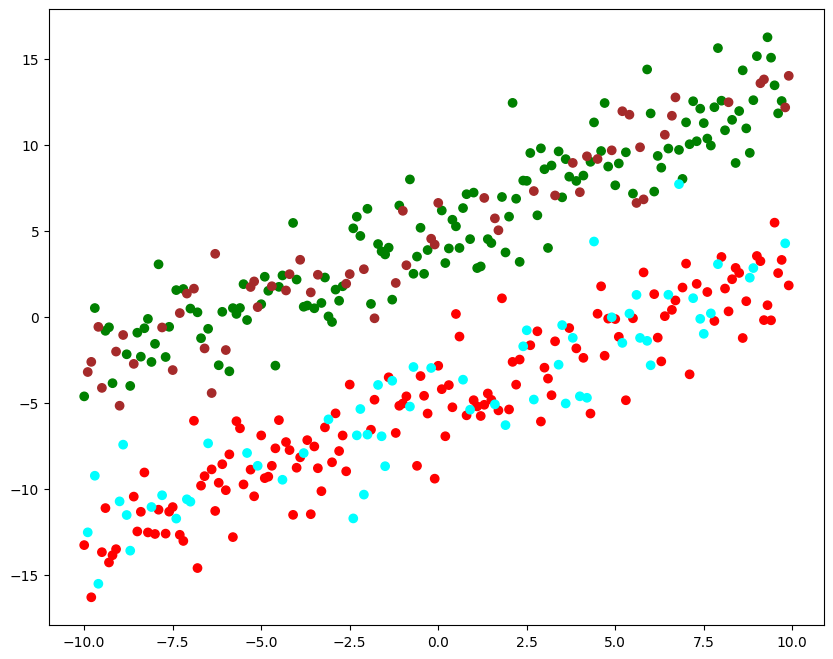

In [3]:
plt.rcParams['figure.figsize'] = [10, 8]


def plot_data(x_train, y_train, x_val, y_val):
    plt.scatter(x_train[0],x_train[1], c = [["red", "green"][int(i)] for i in y_train])
    plt.scatter(x_val[0],x_val[1], c = [["cyan", "brown"][int(i)] for i in y_val])


plot_data(x_train, y_train, x_val, y_val)

## 3. Implementieren eines Perzeptrons
In dieser Aufgabe soll ein einfaches Perzeptron (d.h. beliebig viele Eingabeneuronen und ein Ausgabeneuron) als Klasse implementiert werden. Zunächst beginnen wir mit einigen imports und der Installation des Paketes `jdc`.

In [4]:
import sys
import random
import sympy as sp
from sklearn import metrics as skm
# Um Klassendefinition auf mehrere Zellen aufteilen zu können.
# !{sys.executable} -m pip install jdc
import jdc

Jetzt definieren wir die Klasse `Perzeptron` und den Konstruktor. Der Konstruktor nimmt zwei Parameter:


1.   `input_neurons` eine natürliche Zahl > 0
2.   `learning_rate` eine rationale Zahl > 0

Als Klassenvariablen soll folgendes gespeichert werden:


1.   Die Gewichte `weights` zwischen Eingabeschicht und Ausgabeschicht.
2.   Der Bias `bias`.
3.   Die Lernrate `learning_rate`.

Verwenden Sie für die Initialisierung der Gewichte und des Biases, gleichverteilte Werte zwischen -0.01 und 0.01.





In [5]:
class Perzeptron:
    def __init__(self, eingabe_neuronen, lernrate=0.1):
        self.lerningrate = lernrate
        self.bias = (random.uniform(-0.01,0.01))
        self.weights = np.random.rand(eingabe_neuronen)
        
        for i in range(eingabe_neuronen):
            self.weights[i] = (self.weights[i]*0.02) - 0.01



Als nächstes sollen Sie die Aktivierungsfunktion implementieren. Zur Erinnerung: Ein Perzeptron verwendet die Heavyside-Funktion:
$$\Theta: \mathbb{R} \rightarrow \{0,1\}, \ x \mapsto \begin{cases} 1 \hspace{2mm} & \text{wenn } x > 0 \\[3pt] 0 & \text{sonst}\\ \end{cases}$$

In [6]:
%%add_to Perzeptron
def aktivierungsfkt(self, wert):
    if(wert>0):
        return 1
    else: 
        return 0


Implementieren Sie jetzt die Forward-Pass Methode. Verwenden Sie `self.weights` und `self.bias` um auf die Klassenvariablen zuzugreifen.

**Hinweis:** Vermutlich kennen Sie die Definition des Forward-Passes als:
$$\sum\limits_{i = 1}^{n} w_{i}x_{i} + b = w^Tx + b$$
wobei $n$ die Anzahl der Eingabeneuronen ist. Da $x$ in der transponierten Form gespeichert wurde und Sie vermutlich $w$ als Spaltenvektor gespeichert haben, kann es sinnvoll sein $x^Tw + b$ zu berechnen.

In [7]:
%%add_to Perzeptron
def forward_pass(self, x):
    result = np.matmul(np.array(x).transpose(), self.weights) + self.bias
    return result
             

In der nächsten Methode sollen die Gewichtsänderungen $\Delta w$ und $\Delta b$ für `w` und `b` berechnet werden. Da diese von der Eingabe `x`, dem vorhergesagten Wert `y_pred` und dem tatsächlichen Wert `y_GT` abhängen, werden diese als Parameter übergeben. Achten Sie auch hier auf die Dimension von `x` und `w`.

In [8]:
%%add_to Perzeptron
def backpropagation(self, x_transposed, y_GT, y_pred):
    w_delta = []
    weighted_inputs = self.forward_pass(x_transposed)

    #partial ergibt sich bei Betrachtung der partiellen Ableitungen
    partial = (y_pred-y_GT)*sp.DiracDelta(weighted_inputs)
    for i in range(len(self.weights)):
        w_delta.append(partial* x_transposed[i])
        #partial*x_transposed[i] ist die partielle Ableitung nach dem Gewicht i

    #Ableitung von weighted_inputs nach bias ist immer 1
    #Daher Partielle Ableitung der Fehlerfunktion nach bias immer partial
    return w_delta,partial

In der folgenden Methode sollen Sie den Gradient Descent Algorithmus implementieren, um die Gewichte in `w` und den Bias `b` zu aktualisieren. Gehen Sie davon aus, dass die Gradienten durch `weights_delta` und `bias_delta` gegeben sind.

In [9]:
%%add_to Perzeptron
def gradient_descent(self, w_delta, b_delta):
    for i in range(len(self.weights)):
        self.weights[i] = self.weights[i] - (self.lerningrate * w_delta[i])
        #Gewichte updaten
    self.bias = self.bias - b_delta


Vervollständigen Sie jetzt die `evaluate` Methode. Diese nimmt zwei obligatorische Parameter `x_val` (Modelleingabe) und `y_val` (erwartete Modellausgabe) und berechnet die **Confusion Matrix**. Zusätzlich soll die Methode den **Recall**, **Precision** und den $F_1$**-Score** berechnen und zurückgeben. Der optionale Parameter `print_F1` soll regeln, ob der berechnete $F_1$**-Score** auch ausgeben wird.

In [10]:
%%add_to Perzeptron
def evaluate(self, x_val, y_val, print_F1=True):
    y_calc = []
    for x in x_val:
        y_calc.append(self.aktivierungsfkt(self.forward_pass(x)))
    c_matrix = skm.confusion_matrix(y_val, y_calc)

    TP = c_matrix[0][0]
    FP = c_matrix[0][1]
    TN = c_matrix[1][0]
    FN = c_matrix[1][1]
    
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    if(print_F1):
        F1_score = 2*TP/(2*TP+FP+FN)
        return recall, precision, F1_score
    else:
        return recall, precision
    

Implementieren Sie nun die Methode `trainieren`. Diese nimmt die Trainingsdaten `x_train` (Eingabe) und `y_train` (Label) und Validierungsdaten `x_val` (Eingabe) und `y_val` (Label). Mit dem Parameter `max_epochen` legen Sie die Anzahl der Epochen fest, die trainiert werden sollen. Sie müssen kein *Early Stopping* implementieren. Wenn Sie möchten (kein Muss für volle Punktzahl), können Sie mit Batches > 1 trainieren.

In [11]:
%%add_to Perzeptron
def trainieren(self, x_train, y_train, x_val, y_val, max_epochen):
    n = len(x_train)
    x_trainT = np.array(x_train).transpose()

    for e in range(max_epochen):
        for i in range(n):
            y_pred = self.aktivierungsfkt(self.forward_pass(x_trainT[i]))
            w_delta, b_delta = self.backpropagation(x_trainT[i],y_train[i], y_pred)
            self.gradient_descent(w_delta, b_delta)

    print(self.evaluate(np.array(x_val).transpose(), y_val))
    
    

Erzeugen Sie ein Objekt der Klasse Perzeptron und trainieren Sie das Perzeptron mit einer Lernrate von 0.1 und maximal 5 Epochen. Was fällt Ihnen auf? Welchen Trainings und welchen Validierungsfehler bekommen Sie?

In [12]:
p = Perzeptron(2,0.1)

p.trainieren(x_train, y_train, x_val, y_val, 5)

(0.5514018691588785, 0.9672131147540983, 0.7023809523809523)


Schreiben Sie eine Methode `finde_trennflaeche()`, die die Trennfläche des Modells repräsentiert.

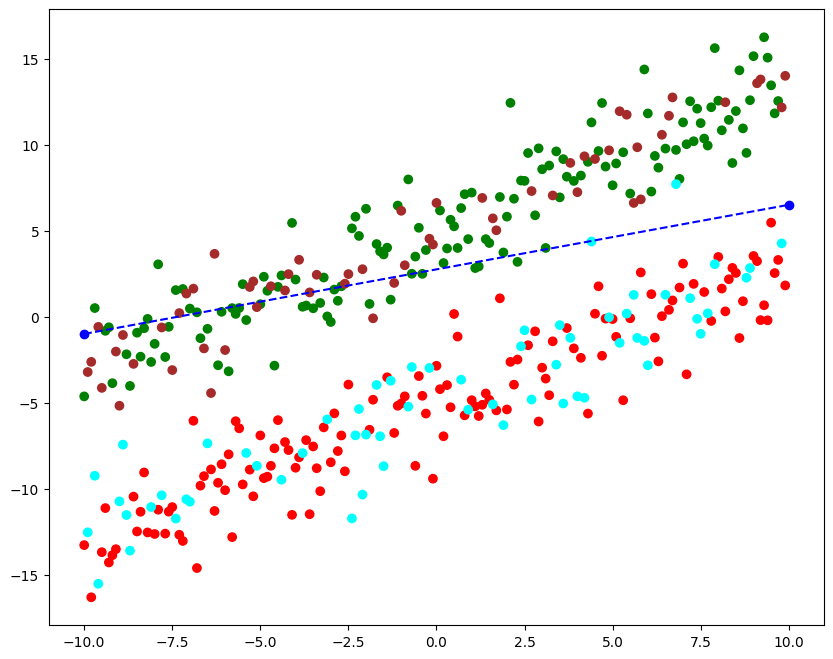

In [13]:
"""
Idee: Da wir Wissen, dass die Trennfläche eine Gerade ist, können wir an den Rändern (auf der x-Achse
bei -10 und 10) von unten nach oben (in y-Richtung) laufen. Sobald ein Wechsel der vorhergesagten Klasse
stattfindet, merken wir uns diesen y-Wert. Wenn wir das an beiden Wändern machen, bekommen wir zwei Tuple
(-10, y_1) und (10, y_2). Diese beiden Punkte können wir zeichnen und eine Gerade durch beide Punkte zeichnen.
"""
def find_point(x,y):
    anfang_klasse = p.aktivierungsfkt(p.forward_pass([x,y]))
    pred_klasse = anfang_klasse
    while(anfang_klasse == pred_klasse):
        pred_klasse = p.aktivierungsfkt(p.forward_pass([x,y]))
        y += 0.5
    return (x, y)

def finde_trennflaeche():
    left_point = find_point(-10, -17)
    right_point = find_point( 10, -17)

    plot_data(x_train, y_train, x_val, y_val)
    plt.plot([left_point[0],right_point[0]],[left_point[1],right_point[1]], 'bo', linestyle="--")
    

finde_trennflaeche()


Denken Sie sich selbst eigene Punkte aus, die Sie anschließend von dem Perzeptron zuordnen lassen.

In [20]:
print(p.aktivierungsfkt(p.forward_pass([0,-3])))

0


Visualisieren Sie zum Schluss noch die Confusion Matrix, die durch die Evaluation des Perzeptrons auf den Validierungsdaten entsteht.

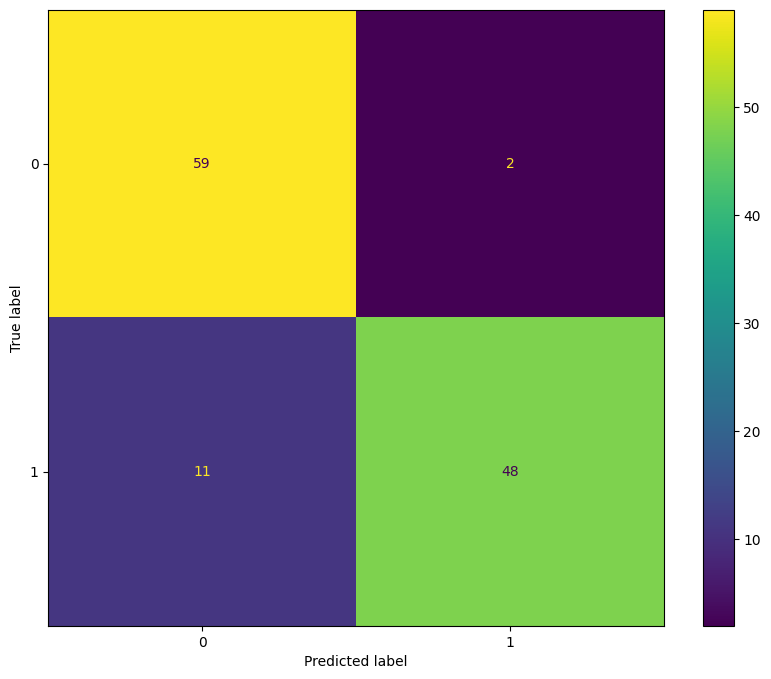

In [18]:
y_calc = []
for x in np.array(x_val).transpose():
    y_calc.append(p.aktivierungsfkt(p.forward_pass(x)))
c_matrix = skm.confusion_matrix(y_val, y_calc)
display = skm.ConfusionMatrixDisplay(confusion_matrix=c_matrix, display_labels = [0,1])
display.plot()
plt.show()